In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers

#### Clone the repository

In [2]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

#### Prepare datasets

In [3]:
directory = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
file_paths = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_paths.append(os.path.join(dirname, filename))

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt


In [4]:
def load_txt_file(file_path):
    with open(file_path, 'r') as f:
        return f.readlines()

In [5]:
train_article = load_txt_file(file_paths[2])
test_article = load_txt_file(file_paths[1])
val_abstract = load_txt_file(file_paths[0])

In [6]:
def process_data(content):
    abstract = []
    line_count = 0
    processed_data = []
    for line in content:
        if line.startswith('###'):
            abstract_id = line[3:-1]
        elif not line.isspace():
            line_count += 1
            splitted_line = line.split('\t')
            target = splitted_line[0]
            text = splitted_line[1][:-1]
            line_number = line_count
            abstract.append({'id': abstract_id, 'line_number': line_number, 'target': target, 'text': text})
        elif line.isspace():
            for dictionary in abstract:
                dictionary['total_lines'] = line_count
                processed_data.append(dictionary)    
            abstract = []
            line_count = 0
    return processed_data
                

In [7]:
train_samples = process_data(train_article)
val_samples = process_data(val_abstract)
test_samples = process_data(test_article)

CPU times: total: 234 ms
Wall time: 228 ms


In [8]:
df_train = pd.DataFrame(train_samples)
df_val = pd.DataFrame(val_samples)
df_test = pd.DataFrame(test_samples) 

In [9]:
df_train

,id,line_number,target,text,total_lines
0,24293578,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,24293578,2,METHODS,A total of @ patients with primary knee OA wer...,12
2,24293578,3,METHODS,Outcome measures included pain reduction and i...,12
3,24293578,4,METHODS,Pain was assessed using the visual analog pain...,12
4,24293578,5,METHODS,Secondary outcome measures included the Wester...,12
...,...,...,...,...,...
180035,26227186,8,RESULTS,For the absolute change in percent atheroma vo...,12
180036,26227186,9,RESULTS,"For PAV , a significantly greater percentage o...",12
180037,26227186,10,RESULTS,Both strategies had acceptable side effect pro...,12
180038,26227186,11,CONCLUSIONS,"Compared with standard statin monotherapy , th...",12


In [36]:
number_of_classes = len(df_train['target'].unique())
number_of_classes

5

In [10]:
df_train['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

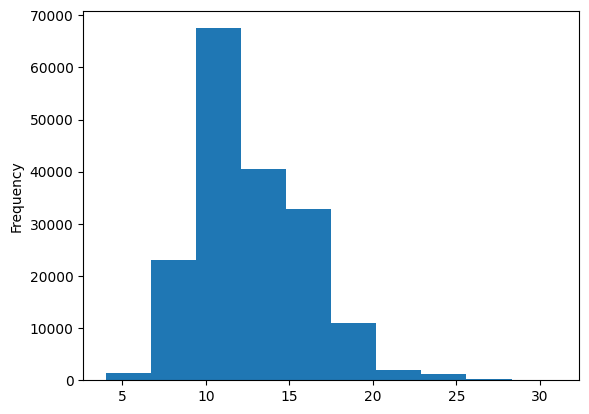

In [11]:
df_train['total_lines'].plot.hist()

#### Get list in to lists

In [12]:
training_sentences = df_train['text'].to_list()
val_sentences = df_val['text'].to_list()
test_sentences = df_test['text'].to_list()

#### One hote encod the labels

In [13]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
One_Hot_Encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = One_Hot_Encoder.fit_transform(df_train['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = One_Hot_Encoder.transform(df_val['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = One_Hot_Encoder.transform(df_test['target'].to_numpy().reshape(-1, 1))

In [14]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
Label_Encoder = LabelEncoder()
train_labels_label_encode = Label_Encoder.fit_transform(df_train['target'].to_numpy())
test_labels_label_encode = Label_Encoder.transform(df_test['target'].to_numpy())
val_labels_label_encode = Label_Encoder.transform(df_val['target'].to_numpy())

#### Helper functions

In [15]:
import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [16]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [17]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Strating modeling experimnets

#### Model 0: Baseline Model (Naivie Bayes with TF-IDF)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [19]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [20]:
model_0.fit(X=training_sentences, y=train_labels_label_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(val_sentences, val_labels_label_encode)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
baseline_results = calculate_results(y_true=val_labels_label_encode, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#### Prepare data for deep sequnce models

In [24]:
words_counts =  [len(sentence.split()) for sentence in training_sentences]
mean_words_count = np.mean(words_counts)
mean_words_count

26.338269273494777

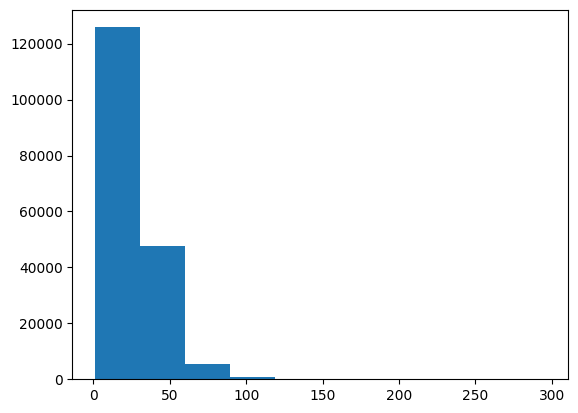

In [25]:
plt.hist(words_counts)
plt.show()

In [26]:
output_seq_len = int(np.percentile(words_counts, 95))
output_seq_len

55

#### Create tokenization and padding

In [27]:
max_tokens = 68000  # form research paper

In [28]:
textVectorization = layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

In [29]:
textVectorization.adapt(training_sentences)

In [30]:
length_of_vocab = len(textVectorization.get_vocabulary())
print('Number of words in vocabulary:', length_of_vocab)
textVectorization.get_config()

Number of words in vocabulary: 64841


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Create text embedding

In [31]:
token_embed = layers.Embedding(input_dim=length_of_vocab, 
                               output_dim=128, 
                               mask_zero=True,
                               name="token_embedding")

#### Create data pipeline

In [32]:
def make_dataset(sentences,labels_one_hot):
    dataset = tf.data.Dataset.from_tensor_slices((sentences, labels_one_hot))
    dataset = dataset.cache()
    # dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [33]:
train_dataset = make_dataset(training_sentences, train_labels_one_hot)
val_dataset = make_dataset(val_sentences, val_labels_one_hot)
test_dataset = make_dataset(test_sentences, test_labels_one_hot)

In [34]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Model 1: Conv1D with token embedding

In [37]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = textVectorization(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(number_of_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [42]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160  

In [44]:
model_1.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset,
            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                    experiment_name="model_1_dense")]) 


Saving TensorBoard log files to: tensorflow_hub/model_1_dense/20240218-010358
Epoch 1/3
5627/5627 [==============================] - 67s 11ms/step - loss: 0.5934 - accuracy: 0.7768 - val_loss: 0.5130 - val_accuracy: 0.8121
Epoch 2/3
5627/5627 [==============================] - 60s 11ms/step - loss: 0.4251 - accuracy: 0.8476 - val_loss: 0.5165 - val_accuracy: 0.8155
Epoch 3/3
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3354 - accuracy: 0.8829 - val_loss: 0.5711 - val_accuracy: 0.8093


In [45]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5711 - accuracy: 0.8093


[0.5710591077804565, 0.8093141913414001]

In [48]:
model_1_pred = model_1.predict(test_dataset)
model_1_pred, model_1_pred.shape

  1/942 [..............................] - ETA: 19s

942/942 [==============================] - 3s 3ms/step


(array([[6.0026282e-01, 1.4590588e-02, 8.5745893e-02, 2.7651072e-01,
         2.2889949e-02],
        [6.5554264e-03, 2.7959261e-03, 7.0057684e-01, 6.1222631e-03,
         2.8394955e-01],
        [1.7415649e-04, 1.1605119e-04, 9.6062404e-01, 2.6099518e-04,
         3.8824771e-02],
        ...,
        [1.5258615e-06, 4.9707396e-03, 1.1041479e-04, 1.3742527e-07,
         9.9491715e-01],
        [1.3374111e-04, 6.0700052e-03, 4.4616889e-03, 2.4363966e-05,
         9.8931026e-01],
        [2.5126152e-04, 3.3572772e-01, 1.4231962e-03, 3.7390098e-05,
         6.6256040e-01]], dtype=float32),
 (30135, 5))

In [53]:
tf.argmax(model_1_pred, axis=1)

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 4], dtype=int64)>

In [50]:
model_1_results = calculate_results(y_true=test_labels_label_encode, y_pred=tf.argmax(model_1_pred, axis=1))
model_1_results

{'accuracy': 80.24556163928986,
 'precision': 0.7985598293013252,
 'recall': 0.8024556163928986,
 'f1': 0.7993173978555669}

#### Model 2: Feature extraction with pretrained token embedding